## **Import Required Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import time
import pickle
from scipy.io import savemat, loadmat

## **Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True, timeout_ms=120000*5)

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/My Drive/Speech_Project/train_16k_standardisation_zeroPadded.zip' -d '/content/'
!unzip -q '/content/drive/My Drive/Speech_Project/test_16k_standardisation_zeroPadded.zip' -d '/content/'

In [ ]:
len(os.listdir('/content/Train/train_input')), len(os.listdir('/content/Train/train_output')),len(os.listdir('/content/Test/test_input')), len(os.listdir('/content/Test/test_output'))

(40332, 40332, 3635, 3635)

In [ ]:
class my_Dataset(Dataset):
    # Characterizes a dataset for PyTorch
    def __init__(self, data_paths, target_paths, transform=None):
        self.data_paths = data_paths
        self.target_paths = target_paths
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, index):
        x = torch.from_numpy(np.expand_dims(np.load(self.data_paths[index]),axis = 0))
        y = torch.from_numpy(np.expand_dims(np.load(self.target_paths[index]),axis = 0))
        if self.transform:
            x = self.transform(x)

        return x, y

root_train_input = '/content/Train/train_input/'
root_train_output = '/content/Train/train_output/' 
root_test_input = '/content/Test/test_input/'
root_test_output = '/content/Test/test_output/' 

train_input = sorted(os.listdir(root_train_input))
train_output = sorted(os.listdir(root_train_output))
test_input = sorted(os.listdir(root_test_input))
test_output = sorted(os.listdir(root_test_output))

train_input = list(map(root_train_input.__add__,train_input))
train_output = list(map(root_train_output.__add__,train_output))
test_input = list(map(root_test_input.__add__,test_input))
test_output = list(map(root_test_output.__add__,test_output))
# print(len(train_output), len(train_input), len(test_output), len(test_input))

train_set = my_Dataset(train_input,train_output) 
test_dataset = my_Dataset(test_input,test_output)       

In [ ]:
generator=torch.Generator().manual_seed(123)
train_dataset, val_dataset = torch.utils.data.random_split(train_set, [round(train_set.__len__()*0.95),round(train_set.__len__()*0.05)],generator=generator)

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=200)
val_loader = DataLoader(val_dataset,batch_size=200)
test_loader = DataLoader(test_dataset,batch_size=200)

## **Data Visualisation**

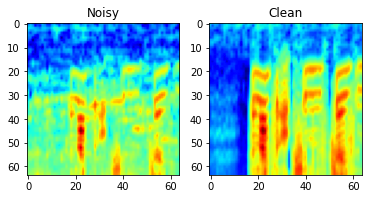

In [ ]:
a,b = next(iter(train_loader))
fig, axs = plt.subplots(1,2)
axs[0].imshow(a[5][0], cmap='jet')
axs[0].set_title('Noisy')
axs[1].imshow(b[5][0], cmap='jet')
axs[1].set_title('Clean')
plt.show()

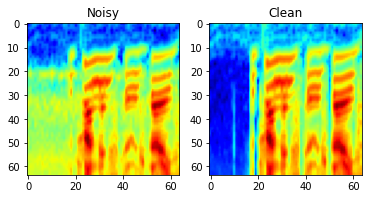

In [ ]:
a,b = next(iter(val_loader))
fig, axs = plt.subplots(1,2)
axs[0].imshow(a[9][0], cmap='jet')
axs[0].set_title('Noisy')
axs[1].imshow(b[9][0], cmap='jet')
axs[1].set_title('Clean')
plt.show()

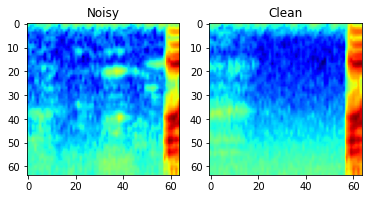

In [ ]:
a,b = next(iter(test_loader))
fig, axs = plt.subplots(1,2)
axs[0].imshow(a[10][0], cmap='jet')
axs[0].set_title('Noisy')
axs[1].imshow(b[10][0], cmap='jet')
axs[1].set_title('Clean')
plt.show()

### **Exploration of mask values**

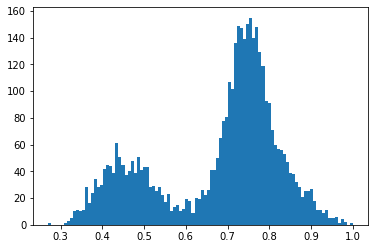

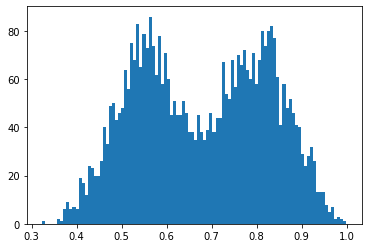

In [ ]:
i = 1
plt.hist(a[i][0].ravel(),bins = 100)
plt.show()

plt.hist(b[i][0].ravel(),bins = 100)
plt.show()

## **Architecture: Implicit CNN-GAN**

### **CNN-GAN model**

#### **Generator**

In [ ]:
class Gen_TF(nn.Module):

    def __init__(self, kernel_size=4, stride=2, filter_size_1=64, filter_size_2=128, filter_size_3=256, filter_size_4=512, bottle_neck_size=100):
        super(Gen_TF, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.filter_size_1 = filter_size_1
        self.filter_size_2 = filter_size_2
        self.filter_size_3 = filter_size_3
        self.filter_size_4 = filter_size_4
        self.bottle_neck_size = bottle_neck_size

        self.conv2d_1 = nn.Conv2d(1, filter_size_1, kernel_size, stride)
        self.conv2d_2 = nn.Conv2d(filter_size_1, filter_size_2, kernel_size, stride)
        self.conv2d_3 = nn.Conv2d(filter_size_2, filter_size_3, kernel_size, stride)
        self.conv2d_4 = nn.Conv2d(filter_size_3, filter_size_4, kernel_size, stride)

        self.flatten = nn.Flatten()
        self.bottle_neck = nn.Linear(filter_size_4*2*2, bottle_neck_size)
        self.bn_to_deconv = nn.Linear(bottle_neck_size, filter_size_4*2*2)
        self.relu = nn.LeakyReLU()                                               
        self.sig = nn.Sigmoid()                           ################## sigmoid to tanh for standardissed data ##########################

        self.batchnorm_encoder1 = nn.BatchNorm2d(filter_size_1)
        self.batchnorm_encoder2 = nn.BatchNorm2d(filter_size_2)
        self.batchnorm_encoder3 = nn.BatchNorm2d(filter_size_3)
        self.batchnorm_encoder4 = nn.BatchNorm2d(filter_size_4)

        self.batchnorm_decoder4 = nn.BatchNorm2d(filter_size_3)
        self.batchnorm_decoder3 = nn.BatchNorm2d(filter_size_2)
        self.batchnorm_decoder2 = nn.BatchNorm2d(filter_size_1)
        self.batchnorm_decoder1 = nn.BatchNorm2d(1)

        self.deconv2d_4 = nn.ConvTranspose2d(filter_size_4, filter_size_3, kernel_size, stride)
        self.deconv2d_3 = nn.ConvTranspose2d(filter_size_3, filter_size_2, kernel_size, stride)
        self.deconv2d_2 = nn.ConvTranspose2d(filter_size_2, filter_size_1, kernel_size, stride, output_padding=1)
        self.deconv2d_1 = nn.ConvTranspose2d(filter_size_1, 1, kernel_size, stride)


    def forward(self, spectrogram):

        x = self.conv2d_1(spectrogram)
        x = self.batchnorm_encoder1(x)
        x = self.relu(x)

        x = self.conv2d_2(x)
        x = self.batchnorm_encoder2(x)
        x = self.relu(x)

        x = self.conv2d_3(x)
        x = self.batchnorm_encoder3(x)
        x = self.relu(x)

        x = self.conv2d_4(x)
        x = self.batchnorm_encoder4(x)
        x = self.relu(x)

        x = self.flatten(x)
        x = self.bottle_neck(x)
        x = self.bn_to_deconv(x)
        x = torch.reshape(x, (-1,512,2,2))

        x = self.deconv2d_4(x)
        x = self.batchnorm_decoder4(x)
        x = self.relu(x)

        x = self.deconv2d_3(x)
        x = self.batchnorm_decoder3(x)
        x = self.relu(x)

        x = self.deconv2d_2(x)
        x = self.batchnorm_decoder2(x)
        x = self.relu(x)

        x = self.deconv2d_1(x)
        x = self.sig(x)

        return x

#### **Discriminator**

In [ ]:
class Dis_TF(nn.Module):

    def __init__(self, kernel_size=4, stride=2, filter_size_1=64, filter_size_2=128, filter_size_3=256, filter_size_4=512, filter_size_5=64, filter_size_6=1):
        super(Dis_TF, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.filter_size_1 = filter_size_1
        self.filter_size_2 = filter_size_2
        self.filter_size_3 = filter_size_3
        self.filter_size_4 = filter_size_4
        self.filter_size_5 = filter_size_5
        self.filter_size_6 = filter_size_6

        self.conv2d_1 = nn.Conv2d(1, filter_size_1, kernel_size, stride)
        self.conv2d_2 = nn.Conv2d(filter_size_1, filter_size_2, kernel_size, stride)
        self.conv2d_3 = nn.Conv2d(filter_size_2, filter_size_3, kernel_size, stride)
        self.conv2d_4 = nn.Conv2d(filter_size_3, filter_size_4, kernel_size, stride)
        self.conv2d_5 = nn.Conv2d(filter_size_4, filter_size_5, 1, 1)
        self.conv2d_6 = nn.Conv2d(filter_size_5, filter_size_6, 1, 1)

        self.flatten = nn.Flatten()
        self.relu = nn.LeakyReLU() 
        self.sigmoid = nn.Sigmoid()

        self.batchnorm_encoder1 = nn.BatchNorm2d(filter_size_1)
        self.batchnorm_encoder2 = nn.BatchNorm2d(filter_size_2)
        self.batchnorm_encoder3 = nn.BatchNorm2d(filter_size_3)
        self.batchnorm_encoder4 = nn.BatchNorm2d(filter_size_4)
        self.batchnorm_encoder5 = nn.BatchNorm2d(filter_size_5)
        self.batchnorm_encoder6 = nn.BatchNorm2d(filter_size_6)

        self.dense = nn.Linear(filter_size_6 * 2 *2 , 1)

    def forward(self, spectrogram):

        x = self.conv2d_1(spectrogram)
        x = self.batchnorm_encoder1(x)
        x = self.relu(x)

        x = self.conv2d_2(x)
        x = self.batchnorm_encoder2(x)
        x = self.relu(x)

        x = self.conv2d_3(x)
        x = self.batchnorm_encoder3(x)
        x = self.relu(x)

        x = self.conv2d_4(x)
        x = self.batchnorm_encoder4(x)
        x = self.relu(x)

        x = self.conv2d_5(x)
        x = self.batchnorm_encoder5(x)
        x = self.relu(x)

        x = self.conv2d_6(x)

        x = self.flatten(x)
        x = self.dense(x)
        x = self.sigmoid(x)

        return x

## **Training loop**

In [ ]:
# shape = (n, 1, 64, 64)
root = '/content/drive/My Drive/Speech_Project/GAN_Implicit/std_sigmoid/'

def train_GAN(train_loader,val_loader, n_epochs=20, lr_gen=0.002, lr_dis = 0.002, continue_train = 0):

    
    if continue_train == 0:
      gen_tf = Gen_TF().cuda()
      gen_tf.double()
      params_gen = gen_tf.parameters()

      dis_tf = Dis_TF().cuda()
      dis_tf.double()
      params_dis = dis_tf.parameters()
      print('params calculated')
      running_loss = {'gen_train': [], 'gen_val': [], 'dis_train': [], 'dis_val':[], 'dis_real':[],'dis_fake': [],'gen_1':[],'gen_2':[]}

      # opt_dis = optim.Adam(dis_tf.parameters(), lr= lr_dis, betas=(0.9, 0.999))
      opt_dis = optim.Adam(dis_tf.parameters(), lr=lr_dis)
      opt_gen = optim.Adam(gen_tf.parameters(), lr= lr_gen) 

    else:
      model_saved = torch.load(root + 'model_iGAN_2.pth.tar')
      gen_tf = model_saved['G model']
      dis_tf = model_saved['D model']
      opt_dis = model_saved['D opt']
      opt_gen = model_saved['G opt']
      with open(root + 'running_loss_iGAN.pickel', 'rb') as f:
          running_loss = pickle.load(f)
          
    criterion = nn.BCELoss() 
    

    print('loaded loss and opt')

    best_val_loss = 10000

    for i in range(n_epochs):

        # opt_gen.zero_grad()
        # opt_dis.zero_grad()

        epoch_loss_gen = 0
        epoch_loss_dis = 0
        val_loss_gen = 0
        val_loss_dis = 0

        epoch_loss_gen_1 = 0
        epoch_loss_gen_2 = 0
        epoch_loss_dis_fake = 0
        epoch_loss_dis_real = 0
        
        for j, (batch_input,real_output) in enumerate(train_loader):

            start = time.time()

            # Dis loss
            dis_tf.zero_grad()
            dis_real = dis_tf(real_output.cuda()).view(-1)
            dis_loss_real = criterion(dis_real, torch.ones_like(dis_real))
            dis_loss_real.backward() 
            opt_dis.step()

            # update for fake samples
            dis_tf.zero_grad()
            fake_output = gen_tf(batch_input.cuda())
            dis_fake = dis_tf(fake_output.cuda()).view(-1)
            dis_loss_fake = criterion(dis_fake, torch.zeros_like(dis_fake))
            dis_loss_fake.backward()      
            opt_dis.step() 

            # Gen loss
            # fake_output = gen_tf(batch_input.cuda())
            gen_tf.zero_grad()
            dis_tf.zero_grad()
            gen_fake = gen_tf(batch_input.cuda())
            fake = dis_tf(gen_fake).view(-1)
            gen_loss_1 = criterion(fake, torch.ones_like(fake))
            gen_loss_2 =  0.5 * torch.mean((real_output.cuda() - gen_fake)**2)
            gen_loss =  gen_loss_1 + gen_loss_2 
            gen_loss.backward()
            opt_gen.step()

            epoch_loss_gen+=gen_loss.item()
            epoch_loss_dis = epoch_loss_dis + dis_loss_real.item() + dis_loss_fake.item()

            epoch_loss_dis_fake += dis_loss_fake.item()
            epoch_loss_dis_real += dis_loss_real.item()
            epoch_loss_gen_1 += gen_loss_1.item()
            epoch_loss_gen_2 += gen_loss_2.item()

            print(f"Epoch [{i}/{n_epochs}] Batch {j}/{len(train_loader)} Loss D_real: {dis_loss_real:.4f}, Loss D_fake: {dis_loss_fake:.4f}, loss G: {gen_loss:.4f}, Time taken: {time.time()-start:.4f}" )

            del batch_input, real_output

        print('\n\n Epoch ',i,' : Train D Loss = ', epoch_loss_dis/len(train_loader), 
              ' : Train G Loss = ', epoch_loss_gen/len(train_loader))
        
        running_loss['dis_train'].append(epoch_loss_dis/len(train_loader))
        running_loss['gen_train'].append(epoch_loss_gen/len(train_loader))
        
        running_loss['dis_fake'].append(epoch_loss_dis_fake/len(train_loader))
        running_loss['dis_real'].append(epoch_loss_dis_real/len(train_loader))
        running_loss['gen_1'].append(epoch_loss_gen_1/len(train_loader))
        running_loss['gen_2'].append(epoch_loss_gen_2/len(train_loader))

        for j, (val_input, real_output) in enumerate(val_loader):

            start = time.time()

            fake_output = gen_tf(val_input.cuda())
            dis_real = dis_tf(real_output.cuda()).view(-1)
            dis_fake = dis_tf(fake_output.cuda()).view(-1)
            # Dis loss
            dis_loss_real = criterion(dis_real, torch.ones_like(dis_real))
            dis_loss_fake = criterion(dis_fake, torch.zeros_like(dis_fake))
            
            dis_loss = (dis_loss_real + dis_loss_fake)

            # Gen loss
            fake = dis_tf(fake_output.cuda()).view(-1)
            gen_loss_1 = criterion(fake, torch.ones_like(fake))
            gen_loss_2 = 0.5 * torch.mean((real_output.cuda() - fake_output)**2) 
            gen_loss = gen_loss_1 + gen_loss_2

            val_loss_gen+=gen_loss.item()
            val_loss_dis+=dis_loss.item()

            print(f"Epoch [{i}/{n_epochs}] Batch {j}/{len(val_loader)} Loss D_real: {dis_loss:.4f}, loss G: {gen_loss:.4f}, Time taken: {time.time()-start:.4f}" )


            del val_input, real_output

        print('             Val D Loss = ',val_loss_dis/len(val_loader),' : Val G Loss = ', val_loss_gen/len(val_loader))
        running_loss['dis_val'].append(val_loss_dis/len(val_loader))
        running_loss['gen_val'].append(val_loss_gen/len(val_loader))
        if val_loss_gen / len(val_loader) < best_val_loss:
        # Save model state after each epoch
          state = {'D model': dis_tf,
                  'G model': gen_tf,
                  'D opt': opt_dis,
                  'G opt':opt_gen}

          filename = root + 'model_iGAN_bestval.pth.tar'
          torch.save(state, filename)
          best_val_loss = val_loss_gen / len(val_loader)
          print('             Checkpointed model state: Best_VAL')

        print("Current Best Validation Loss: ", best_val_loss)

        state = {'D model': dis_tf,
                  'G model': gen_tf,
                  'D opt': opt_dis,
                  'G opt':opt_gen}
        filename = root + 'model_iGAN.pth.tar'
        torch.save(state, filename)
        print('             Checkpointed model state: Current_model')

        with open(root + 'running_loss_iGAN.pickel', 'wb') as f:
              pickle.dump(running_loss, f)
        torch.cuda.empty_cache()
        

    return running_loss, dis_tf, gen_tf


In [ ]:
running_loss, model_D, model_G = train_GAN(train_loader,val_loader, n_epochs = 30, lr_gen=0.002, lr_dis = 0.002, continue_train=0)

In [ ]:
root = '/content/drive/My Drive/Speech_Project/GAN_Implicit/std_sigmoid/'
with open(root + 'running_loss_iGAN_3.pickel', 'rb') as f:
    running_loss = pickle.load(f)

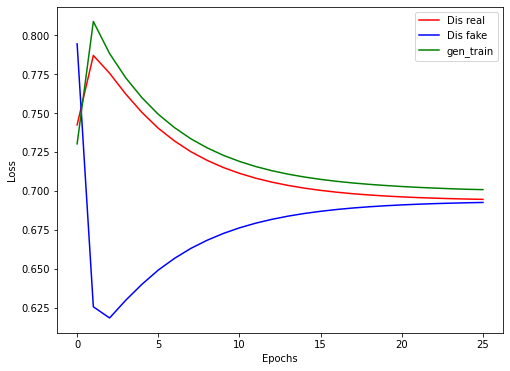

In [ ]:
num_epochs = range(0,len(running_loss['gen_train'])-5)

plt.figure(figsize = (8,6))
plt.plot(num_epochs, running_loss['dis_real'][:26],'r')
plt.plot(num_epochs, running_loss['dis_fake'][:26],'b')
plt.plot(num_epochs, running_loss['gen_train'][:26],'g')

plt.legend(['Dis real','Dis fake', 'gen_train'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## **Evaluation on testing set**

In [ ]:
torch.cuda.get_device_name()

'Tesla K80'

In [ ]:
root = '/content/drive/My Drive/Speech_Project/GAN_Implicit/norm_tanh/'
model_loaded = torch.load(root + 'model_iGAN_bestval_norm_2.pth.tar')

In [ ]:
val_loss_gen = 0
val_loss_dis = 0
dis_tf = model_loaded['D model']
gen_tf = model_loaded['G model']
criterion = nn.BCELoss()

for j, (val_input, real_output) in enumerate(test_loader):

            start = time.time()

            fake_output = gen_tf(val_input.cuda())
            dis_real = dis_tf(real_output.cuda()).view(-1)
            dis_fake = dis_tf(fake_output.cuda()).view(-1)
            # Dis loss
            dis_loss_real = criterion(dis_real, torch.ones_like(dis_real))
            dis_loss_fake = criterion(dis_fake, torch.zeros_like(dis_fake))
            
            dis_loss = (dis_loss_real + dis_loss_fake)

            # Gen loss
            fake = dis_tf(fake_output.cuda()).view(-1)
            gen_loss_1 = criterion(fake, torch.ones_like(fake))
            gen_loss_2 = 0.5 * torch.mean((real_output.cuda() - fake_output)**2) 
            gen_loss = gen_loss_1 + gen_loss_2
            val_loss_gen+=gen_loss.item()
            val_loss_dis+=dis_loss.item()

            print(f"Epoch [{i}/{1}] Batch {j}/{len(test_loader)} Loss D_real: {dis_loss:.4f}, loss G: {gen_loss:.4f}, Time taken: {time.time()-start:.4f}" )
print('\n             Val D Loss = ',val_loss_dis/len(test_loader),' : Val G Loss = ', val_loss_gen/len(test_loader))

Epoch [823/1] Batch 0/19 Loss D_real: 1.3857, loss G: 0.9682, Time taken: 0.4222
Epoch [823/1] Batch 1/19 Loss D_real: 1.3857, loss G: 0.9712, Time taken: 0.3472
Epoch [823/1] Batch 2/19 Loss D_real: 1.3857, loss G: 0.9696, Time taken: 0.3468
Epoch [823/1] Batch 3/19 Loss D_real: 1.3857, loss G: 0.9742, Time taken: 0.3402
Epoch [823/1] Batch 4/19 Loss D_real: 1.3857, loss G: 0.9662, Time taken: 0.3373
Epoch [823/1] Batch 5/19 Loss D_real: 1.3857, loss G: 0.9651, Time taken: 0.3443
Epoch [823/1] Batch 6/19 Loss D_real: 1.3857, loss G: 0.9683, Time taken: 0.3346
Epoch [823/1] Batch 7/19 Loss D_real: 1.3858, loss G: 0.9766, Time taken: 0.3448
Epoch [823/1] Batch 8/19 Loss D_real: 1.3858, loss G: 0.9445, Time taken: 0.3613
Epoch [823/1] Batch 9/19 Loss D_real: 1.3858, loss G: 0.9511, Time taken: 0.3460
Epoch [823/1] Batch 10/19 Loss D_real: 1.3858, loss G: 0.9580, Time taken: 0.3353
Epoch [823/1] Batch 11/19 Loss D_real: 1.3857, loss G: 0.9481, Time taken: 0.3437
Epoch [823/1] Batch 12/19 

In [ ]:
losses = 0
model_G = model_loaded['G model']
for input, output in test_loader:
    in_ = input
    fake_output = model_G(input.cuda()).cpu()
    out = output
    break

In [ ]:
fake_output = torch.where(in_ == 0, fake_output, fake_output/in_)

In [ ]:
fake_output = fake_output.detach().numpy()

In [ ]:
for index in range(0,20):
  fig, ax = plt.subplots(1,3, figsize = (10,8))
  ax[0].imshow(in_[index].squeeze(0),cmap = 'jet')
  ax[1].imshow(fake_output[index].squeeze(0),cmap = 'jet')
  ax[2].imshow(out[index].squeeze(0),cmap = 'jet')
  plt.show()

## **Save Predicted Gtgrams**

In [ ]:
root = '/content/drive/My Drive/Speech_Project/GAN_Implicit/std_sigmoid/'
model_loaded = torch.load(root + 'model_iGAN.pth.tar')
model = model_loaded['G model']

In [ ]:
root = '/content/Test/test_input/'
os.mkdir('/content/predicted/')
save_root = '/content/predicted/'
test_files = os.listdir(root)
audios = []
for name in test_files:
    audio = '_'.join(name.split('_')[:3])
    if audio not in audios:
      audios.append(audio)

In [ ]:
for i,name in enumerate(audios):
  input_files = sorted(list(filter(lambda x: x.startswith(name + "_") , test_files)))
  positions = np.argsort([int(x.split('.')[0].split('_')[-1])-1 for x in input_files])
  #ordered_files = input_files[positions]
  
  input_arr = []
  for filename in input_files:
    x = np.expand_dims(np.load(root+filename),axis = 0)
    input_arr.append(x)
  model_input = torch.from_numpy(np.array(input_arr))
  model_output = model(model_input.cuda()).detach().cpu().numpy()
  arranged_out = model_output[positions]
  concat_out = np.concatenate((arranged_out), axis = 2)

  savemat( save_root+name+'.mat', mdict = {'PRED_SPEC': concat_out[0]})

In [ ]:
!zip -q -r spec_iGAN_Implicit.zip 'predicted'

In [ ]:
!cp '/content/spec_iGAN_Implicit.zip' '/content/drive/My Drive/Speech_Project/GAN_Implicit/'